# Exercise 2
*CS-E5885 Modeling Biological Networks* <br>
*12.11.2025* <br>

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

## 0. Introduction

### Numerical solution of ODEs

Consider a dynamical system with state $\textbf{x}(t) \in \mathbb{R}_+^{2}$, where $x_1(t)$ and $x_2(t)$ are concentrations of molecules A and B at time $t \geq 0$, respectively. The initial concentrations are $\textbf{x}(0) = [2.2, 1.0]^{\top}$ and assumed to be known. The dynamics are modeled using a coupled ODE (ordinary differential equation) system

$$
\begin{align}
& \frac{\text{d}\textbf{x}(t)}{\text{d}t} = f(\textbf{x}(t), \textbf{k}) & (Eq. 1)
\end{align}
$$

where

$$
f(\bf{x}, \bf{k}) = 
\begin{bmatrix} 
f_1(\bf{x}, \bf{k}) \\
f_2(\bf{x}, \bf{k})
\end{bmatrix} =
\begin{bmatrix} 
2 x_1 - k_1 x_1 x_2 \\
k_1 x_1 x_2 - k_2 x_2
\end{bmatrix}
$$

and $\textbf{k} = [k_1, k_2]$ are deterministic rate constants. Below is an example that shows how to solve $\textbf{x}(t)$ numerically using [scipy.integrate.solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html), with some given value of $\textbf{k}$ (`k_example`). 

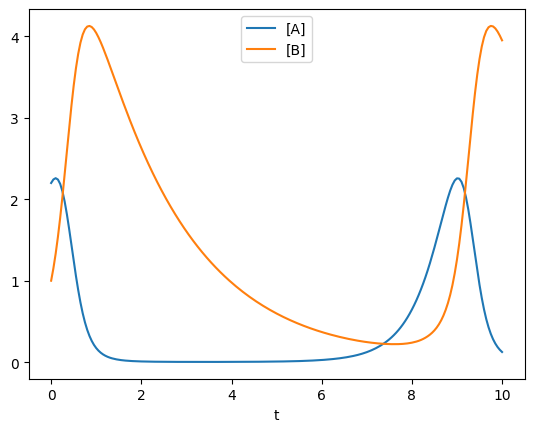

In [2]:
# This function implements f(x, k)
def odefun(x, k):
    """Differential function of the ODE system.
    
    :param x: a list with length 2, i.e. values of the dynamical variables
    :param k: parameters, a list with length 2
    :returns: dx/dt, a list with length 2
    """
    dx1_dt = 2.0*x[0] - k[0]*x[0]*x[1]
    dx2_dt = k[0]*x[0]*x[1] - k[1]*x[1]
    dx_dt = [dx1_dt, dx2_dt]
    return dx_dt

# Using scipy.integrate.solve_ivp() to solve x(t) in the interval [0, 10] with given an example value of k
x0 = [2.2, 1.0]
t_eval = np.linspace(0,10,201)
k_example = [1.5, 0.5]

fun = lambda t,y: odefun(x=y, k=k_example) # differential function with fixed k values
out = solve_ivp(fun, y0=x0, t_span=[0, max(t_eval)], t_eval=t_eval) # solve the initial value problem

# Plot solution
X_out = out.y.T
plt.figure()
plt.plot(t_eval, X_out[:, 0])
plt.plot(t_eval, X_out[:, 1])
plt.legend(['[A]', '[B]'])
plt.xlabel('t')
plt.show()

### Data for the exercise

In this exercise, we don't know the values of the parameters $\textbf{k}$ and wish to optimize them based on the below data. The first column of `Y_data` corresponds to $x_1(t)$ and second to $x_2(t)$.

In [3]:
t_data = np.linspace(1,10,20)
Y_data = np.array([
    [2.46453992, 3.60858988],
    [1.36147358, 2.94974486],
    [0.83659004, 2.42189492],
    [0.63479081, 1.21896289],
    [1.96550665, 0.79799601],
    [2.8, 1.2],
    [3.9317634,  1.85744158],
    [2.37791467, 3.43918307],
    [1.63918609, 3.56459394],
    [1.13540439, 2.03678334],
    [1.30275284, 1.52561854],
    [1.62360963, 1.17760926],
    [2.68444394, 0.98298436],
    [3.83887552, 1.88928201],
    [2.23165204, 3.46577548],
    [1.07424108, 2.4358289 ],
    [0.57951303, 1.70852535],
    [1.38550887, 1.13571176],
    [1.8, 1.1],
    [2.90236636, 1.2190146 ]])

## 1. Target function (1 p)

To emphasis the dependency of the solution $\textbf{x}(t)$ on the parameters we now start denoting it by $\textbf{x}_\textbf{k}(t)$. We will be optimizing the parameters $\textbf{k}$ based on the data, by minimizing a target function which is 

$$
L(\textbf{k}) = \sum_{i=1}^{N} \| \textbf{y}_{i}^\top - \textbf{x}_{\textbf{k}}(t_i)\|^2
$$
where 

* $N$ is the number of observations
* $\textbf{y}_{i}$ is the $i$ th row of `Y_data`
* $t_i$ is the $i$ th value of `t_data`, and
* $\|\textbf{v}\| = \sqrt{v_1^2 + v_2^2}$ is the Euclidean norm of vector $\textbf{v}$.

**a)** Write a python function which evaluates the target function at given point $\textbf{k}$.

In [37]:
def target_function(k):
    """Sum of squared errors.
    :param k: Rate parameters. A list with length 2.
    :return: A real number.
    """
    fun = lambda t,y: odefun(x=y, k=k) # differential function with fixed k values
    out = solve_ivp(fun, y0=x0, t_span=[0, max(t_data)], t_eval=t_data) # solve the initial value problem
    X_out = out.y.T
    residuals = Y_data - X_out
    sse = np.sum(residuals**2)
    return sse   

**b)** What is the value of the target function at point $\textbf{k} = [1.1, 1.7]^{\top}$?

In [5]:
ans= target_function([1.1, 1.7])
print(ans)

20.03889539956201


20.03889539956201

**c)** Run the following block which visualizes the target function. What do you think are the optimal parameter values?

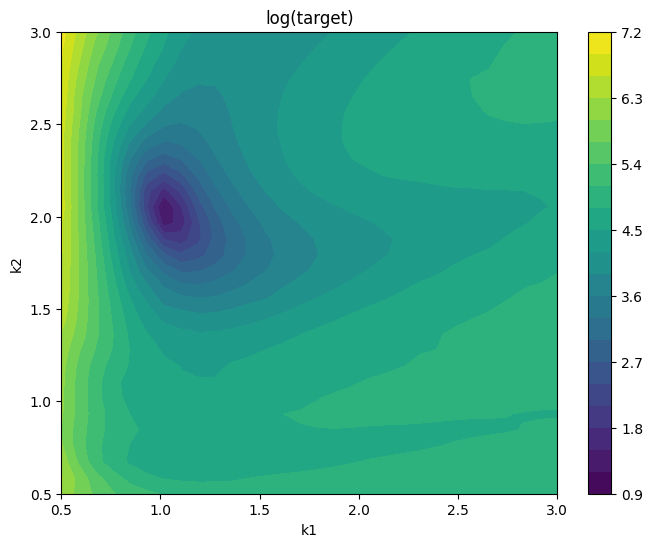

In [6]:
def target_grid(N=30):
    h = np.linspace(0.5, 3, N)
    x, y = np.meshgrid(h, h)
    z = np.zeros(x.shape)
    for i in range(0, N):
        for j in range(0, N):
            k_ij = [x[i,j], y[i,j]]
            z[i,j] = target_function(k_ij)
    return x, y, z
        
def plot_grid(x, y, z, show = True):
    plt.figure(figsize=(8,6))
    plt.contourf(x, y, np.log(z), levels = 20)
    plt.colorbar()
    plt.title('log(target)')
    plt.xlabel('k1')
    plt.ylabel('k2')
    if show:
        plt.show()

x_grid,y_grid,z_grid = target_grid()
plot_grid(x_grid,y_grid,z_grid)

By looking at the plot, we can evaluate the global minimum for the function. The global minimum is colored darkest in this plot and it seems to be around k=[1.0, 2.0]. The smallest function value is the most optimal, so we can confirm this by taking the answer based on these k values.

In [7]:
ans= target_function([1.0, 2.0])
print(ans)

3.531459336672593


small value yay!

## 2. Gradient of the target function (3 p)

(Here we simplify notation by not explicitly writing the dependency of $\textbf{x}(t_i)$ on $\textbf{k}$). In reality the number of parameters could be very large and it would not be possible to infer them based on a plot/grid search like in the previous problem. We would need to use some optimization algorithm. Optimization algorithms typically require the gradient of the objective function. For our target function, the gradient can be written as

$$
\begin{align*}
\frac{\text{d}L(\textbf{k})}{\text{d}\textbf{k}} &= \sum_{i=1}^{N} \frac{\text{d}}{\text{d}\textbf{k}} \| \textbf{y}^\top_{i} - \textbf{x}(t_i)\|^2 = -2 \sum_{i=1}^{N} \left[ \frac{\text{d} \textbf{x}(t_i)}{\text{d}\textbf{k}} \right]^\top \left( \textbf{y}^\top_{i} - \textbf{x}(t_i) \right).
\end{align*}
$$

The problem is that we do not directly know the sensitivities $\textbf{s}(t_i) = \frac{\text{d}\textbf{x}(t_i)}{\text{d}\textbf{k}} \in \mathbb{R}^{2 \times 2}$, i.e. information about how each dimension of $\textbf{x}(t_i)$ changes when the values of the parameters $\textbf{k}$ change.

They can be solved from an additional ODE given by the sensitivity equations

$$
 \frac{\text{d} \textbf{s}(t)}{\text{d}t} = \textbf{J}_x \textbf{s}(t) + \textbf{J}_k
$$

simultaneously with the original system (see Lecture 6). 

**a)** Write the Jacobian matrices $\textbf{J}_x =  \frac{\partial \textbf{f}}{\partial \textbf{x}}$ and $\textbf{J}_k =  \frac{\partial \textbf{f}}{\partial \textbf{k}}$ for our system in $Eq. 1$.

**b)** Complete the function below, which computes $\frac{\text{d} \tilde{\textbf{x}}(t)}{\text{d}t}$, where

* $\tilde{x}_1$ is $x_1$
* $\tilde{x}_2$ is $x_2$ 
* $\tilde{x}_3$ is $\frac{d x_1}{d k_1}$
* $\tilde{x}_4$ is $\frac{d x_1}{d k_2}$
* $\tilde{x}_5$ is $\frac{d x_2}{d k_1}$
* $\tilde{x}_6$ is $\frac{d x_2}{d k_2}$


In [8]:
def odefun_extended(x_tilde, k):
    """Differential function of the extended ODE system.
    
    :param x: a list with length 6, where first 2 are values of the dynamical variables
        and rest are sensitivities
    :param k: a list with length 2
    :returns: dx_tilde/dt a list with length 6
    """
    x1 = x_tilde[0]
    x2 = x_tilde[1]
    # Original system (f1, f2)
    f1 = 2*x1 - k[0]*x1*x2
    f2 = k[0]*x1*x2 - k[1]*x2
    # Jacobian matrices
    Jx = np.array([[2-k[0]*x2, -k[0]*x1],
                   [k[0]*x2, k[0]*x1 - k[1]]])
    
    Jk = np.array([[-x1*x2, 0],
                    [x1*x2, -x2]])

    # Compute derivative
    #let's define x3, x4, x5, x6 into a matrix form for easier computation
    S = np.array([[x_tilde[2], x_tilde[3]],
                  [x_tilde[4], x_tilde[5]]])  # Sensitivity matrix
    rates = Jx @ S + Jk
    dx_tilde_dt=np.array([f1, f2, rates[0,0], rates[0,1], rates[1,0], rates[1,1]])
    return dx_tilde_dt

**c)** Complete the below function which computes the gradient of the target function.

In [45]:
def target_grad(k):
    """Gradient of the target function.
    
    :param k: an array with length 2
    :returns: dL/dk, an array with length 2
    """
    N = len(t_data)
    s0 = np.array([0,0,0,0]) # we know that sensitivity at t=0 is zero because initial value is fixed
    x0_tilde = np.concatenate((x0, s0))
    t_ext = np.concatenate(([0.0], t_data)) # we add point t=0
    fun_extended = lambda t,y: odefun_extended(x_tilde=y,k=k)
    out = solve_ivp(fun_extended, y0=x0_tilde, t_span=[0, max(t_ext)], t_eval=t_ext)
    X_tilde = out.y.T[1:(N+1),:] # remove point at t=0

    grad = np.zeros(2)
    # Compute and return gradient of the objective using the solved X_tilde
    for i in range(N):
        residual = Y_data[i,:] - X_tilde[i,0:2] # y_i - x(t_i)
        sensitivity = X_tilde[i,2:6].reshape((2,2)) # sensitivity matrix at time t_i
        grad += -2 * sensitivity.T @ residual
    return grad


**d)** Run the following code which visualizes the gradient at one point. Comment briefly.

[78.31020938  4.4370408 ]


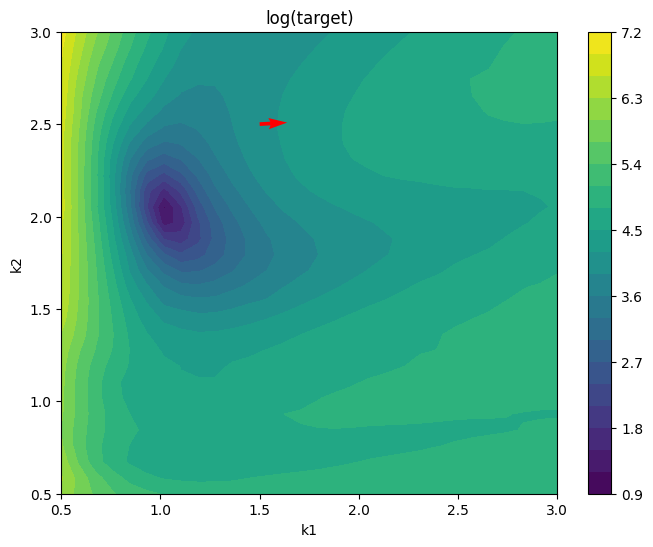

In [46]:
k = [1.5,2.5]
grad = target_grad(k)
print(grad)

plot_grid(x_grid,y_grid,z_grid, show=False)
plt.quiver(k[0], k[1], grad[0], grad[1], color = "red")
plt.show()

Based on the plot and grad values, the k1 and k2 values should be decreased to improve model fit:


[ 1.57110006 -0.40934546]


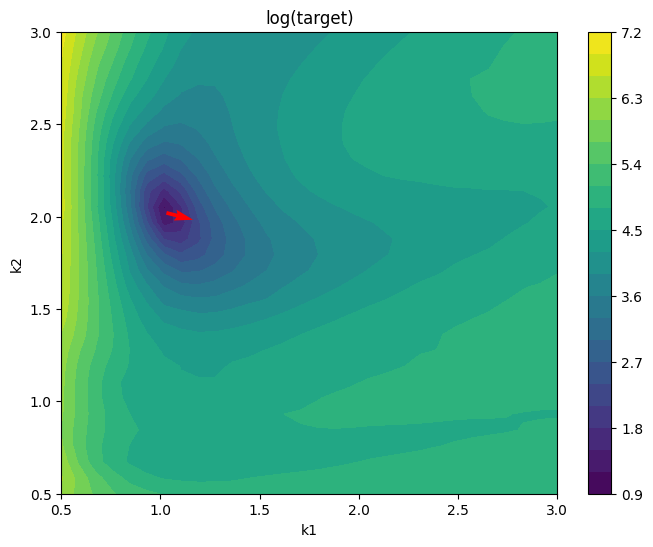

In [57]:
k = [1.03,2.02]
grad = target_grad(k)
print(grad)

plot_grid(x_grid,y_grid,z_grid, show=False)
plt.quiver(k[0], k[1], grad[0], grad[1], color = "red")
plt.show()

## 3. Gradient descent optimization (1 p)

**a)** Complete the below function which optimizes the parameters **k**. It should otherwise work like the gradient descent algorithm (Lecture  6) but you don't need to do the line search, or compare the current objective function value with the previous value. Instead use a fixed step size `r` and a fixed number of iterations.

In [53]:
def grad_descent(k0, n_iter, r):
    """Gradient descent optimization without line search.
    :param k0: Initial guess for the parameter values. List of length 2.
    :param n_iter: Number of iterations.
    :param r: Step size. Positive real number.
    :return: The optimization path in an array with shape [n_iter+1, len(k0)].
    """
    K_path = np.zeros((n_iter+1, len(k0)))
    K_path[0,:] = k0
    for i in range(n_iter):
        k = np.copy(K_path[i,:]) # current parameter values
        K_path[i+1,:] = k -r * target_grad(k)
    return(K_path)
        

**b)** Run the optimization, starting from initial value `k0 = [2.0,1.5]`. Set number of iterations to 50 and use $r = 0.001$. Plot the optimization path using the function below.

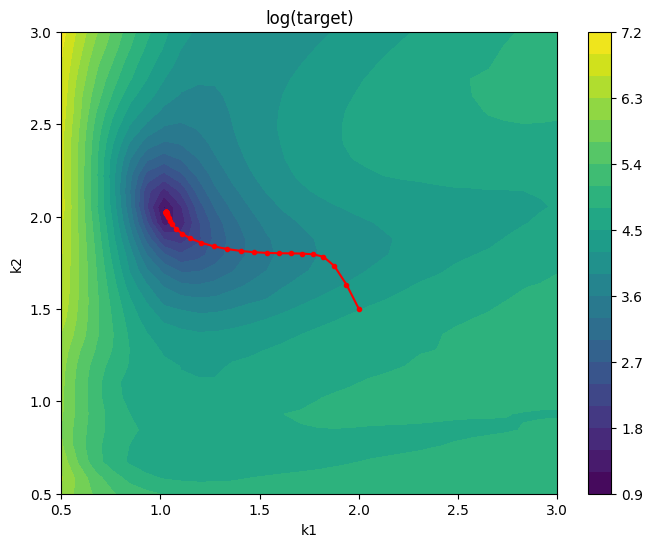

Final parameters k1 and k2: [1.02773374 2.02235802]


In [58]:
K_path = grad_descent(k0=[2.0, 1.5], n_iter=50, r=0.001)

def plot_path(K_path):
    plot_grid(x_grid, y_grid, z_grid,  show=False)
    plt.plot(K_path[:,0], K_path[:,1], 'r.-')
    plt.show()

plot_path(K_path)
print("Final parameters k1 and k2:", K_path[-1,:])

**c)** What were the optimal parameter values that you found? Solve the ODE system with the optimal parameter values at 201 equally spaced points on the interval $t \in [0, 10]$ and plot the solution in separate panels for $x_1(t)$ and $x_2(t)$. Plot also the data in both panels. What happens if you instead start from `k0 = [2.0,0.5]`? Comment on the results.

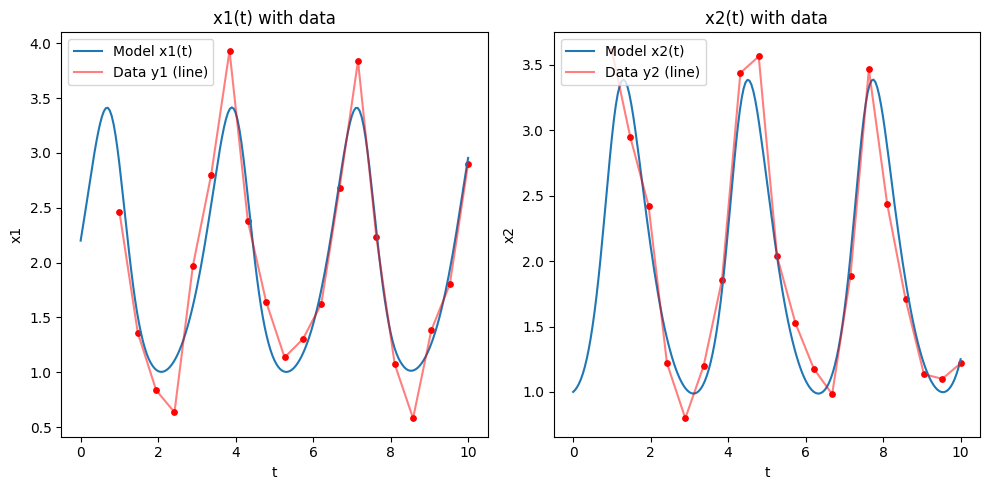

In [65]:
#initial values for the ODE system
x0 = [2.2, 1.0]
t_eval = np.linspace(0,10,201)
k_opt = [1.02773374, 2.02235802]

fun = lambda t,y: odefun(x=y, k=k_opt) # differential function with fixed k values
out_opt = solve_ivp(fun, y0=x0, t_span=[0, max(t_eval)], t_eval=t_eval) # solve the initial value problem

# Plot solution
X_opt = out_opt.y.T

plt.figure(figsize=(10,5))

# ----- Panel 1 -----
plt.subplot(1,2,1)
plt.plot(t_eval, X_opt[:,0], label="Model x1(t)")
plt.scatter(t_data, Y_data[:,0], color='red', s=15)
plt.plot(t_data, Y_data[:,0], color='red', alpha=0.5, label="Data y1 (line)")  
plt.xlabel("t")
plt.ylabel("x1")
plt.title("x1(t) with data")
plt.legend()

# ----- Panel 2 -----
plt.subplot(1,2,2)
plt.plot(t_eval, X_opt[:,1], label="Model x2(t)")
plt.scatter(t_data, Y_data[:,1], color='red', s=15)
plt.plot(t_data, Y_data[:,1], color='red', alpha=0.5, label="Data y2 (line)")
plt.xlabel("t")
plt.ylabel("x2")
plt.title("x2(t) with data")
plt.legend()

plt.tight_layout()
plt.show()



Optimized parameter model fits data well. Realistic oscillations are produced.

start from `k0 = [2.0,0.5]`

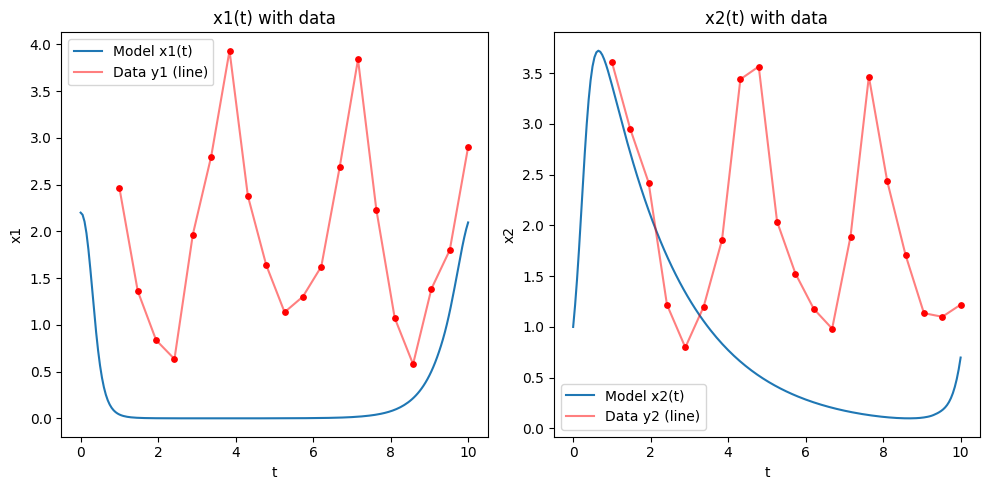

In [67]:
#initial values for the ODE system
x0 = [2.2, 1.0]
t_eval = np.linspace(0,10,201)
k_opt = [2.0, 0.5]

fun = lambda t,y: odefun(x=y, k=k_opt) # differential function with fixed k values
out_opt = solve_ivp(fun, y0=x0, t_span=[0, max(t_eval)], t_eval=t_eval) # solve the initial value problem

# Plot solution
X_opt = out_opt.y.T

plt.figure(figsize=(10,5))

# ----- Panel 1 -----
plt.subplot(1,2,1)
plt.plot(t_eval, X_opt[:,0], label="Model x1(t)")
plt.scatter(t_data, Y_data[:,0], color='red', s=15)
plt.plot(t_data, Y_data[:,0], color='red', alpha=0.5, label="Data y1 (line)")  
plt.xlabel("t")
plt.ylabel("x1")
plt.title("x1(t) with data")
plt.legend()

# ----- Panel 2 -----
plt.subplot(1,2,2)
plt.plot(t_eval, X_opt[:,1], label="Model x2(t)")
plt.scatter(t_data, Y_data[:,1], color='red', s=15)
plt.plot(t_data, Y_data[:,1], color='red', alpha=0.5, label="Data y2 (line)")
plt.xlabel("t")
plt.ylabel("x2")
plt.title("x2(t) with data")
plt.legend()

plt.tight_layout()
plt.show()

Model doesn't fit data. K values are too far from the global minimum to be "pulled" there. The x1 and x2 values are being forced to zero, because k1 is too large (caluclated from k1 * x1 * x2 in ODE)